In [28]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

Make some data

In [29]:
import sklearn
from sklearn.datasets import make_circles

## make 1000 samples

n_samples=1000

x,y=make_circles(n_samples,noise=0.03,random_state=42)

In [30]:
len(x),len(y)

(1000, 1000)

In [31]:
import pandas as pd
circles=pd.DataFrame({"x1":x[:,0],"x2":x[:,1],"label":y})

In [32]:
circles

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


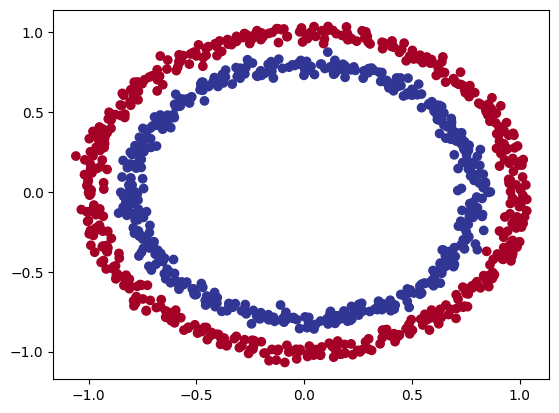

In [33]:
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Check input and output shape

In [34]:
x.shape,y.shape

((1000, 2), (1000,))

In [35]:
#view the first example of features and labels
x_sample=x[0]

Turn data into tensors and create train and test splits

In [36]:
x=torch.from_numpy(x).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32) 

In [37]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

Building a model

In [38]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [39]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(in_features=2,out_features=5)
        self.layer2=nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

In [40]:
model=CircleModel().to(device)


In [41]:
next(model.parameters()).device

device(type='cuda', index=0)

In [42]:
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=128,bias=True),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=1,bias=True)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1, bias=True)
)

In [43]:
preds=model_0(x_test.to(device))
len(preds)

200

In [44]:
loss_fn=nn.BCEWithLogitsLoss()#with sigmoid function
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.2)


In [45]:
def accuracy_fn(y_true,y_pred):
    correct=0
    correct+=torch.eq(y_true.to(device),y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

In [46]:
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [47]:
epoches=1000
epoch_count=[]
train_losses=[]
test_losses=[]
acces=[]
for epoch in tqdm(range(epoches)):
    model_0.train()
    y_logits=model_0(x_train).squeeze()
    y_preds=torch.round(torch.sigmoid(y_logits))
    train_loss=loss_fn(y_logits,y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        logits=model_0(x_test).squeeze()
        test_loss=loss_fn(logits,y_test)
        preds=torch.round(torch.sigmoid(logits))
        acc=accuracy_fn(preds,y_test)
        if(acc==100): break
        torch.save(model_0.state_dict(),"model_parameters/best_model.pth")
    if epoch%10==0:
        epoch_count.append(epoch)
        train_losses.append(train_loss.detach().cpu().numpy())
        test_losses.append(test_loss.detach().cpu().numpy())
        acces.append(acc)
        print(f"Epoch:{epoch} | Loss:{train_loss} | Test loss:{test_loss} | ACC:{acc}")     
        

  3%|▎         | 31/1000 [00:00<00:09, 97.82it/s]

Epoch:0 | Loss:0.6928074359893799 | Test loss:0.6953144073486328 | ACC:46.5
Epoch:10 | Loss:0.6826821565628052 | Test loss:0.6852055788040161 | ACC:53.0
Epoch:20 | Loss:0.673320472240448 | Test loss:0.6770563125610352 | ACC:65.0
Epoch:30 | Loss:0.6640871167182922 | Test loss:0.6692546010017395 | ACC:72.5


  7%|▋         | 69/1000 [00:00<00:06, 149.35it/s]

Epoch:40 | Loss:0.6549099683761597 | Test loss:0.661533772945404 | ACC:75.5
Epoch:50 | Loss:0.6457585096359253 | Test loss:0.653826892375946 | ACC:85.0
Epoch:60 | Loss:0.6366005539894104 | Test loss:0.64610356092453 | ACC:91.0
Epoch:70 | Loss:0.6274141073226929 | Test loss:0.638342022895813 | ACC:92.5
Epoch:80 | Loss:0.6181761622428894 | Test loss:0.6304976344108582 | ACC:93.5


  9%|▉         | 90/1000 [00:00<00:05, 166.82it/s]

Epoch:90 | Loss:0.6088679432868958 | Test loss:0.6225553750991821 | ACC:94.5
Epoch:100 | Loss:0.599490761756897 | Test loss:0.6145305633544922 | ACC:94.5


 15%|█▌        | 153/1000 [00:01<00:05, 154.41it/s]

Epoch:110 | Loss:0.5900532603263855 | Test loss:0.6064059138298035 | ACC:94.5
Epoch:120 | Loss:0.5805478692054749 | Test loss:0.5981956124305725 | ACC:95.5
Epoch:130 | Loss:0.5709646940231323 | Test loss:0.5898886919021606 | ACC:95.5
Epoch:140 | Loss:0.5612910389900208 | Test loss:0.5814984440803528 | ACC:97.0
Epoch:150 | Loss:0.5515645742416382 | Test loss:0.573000967502594 | ACC:97.5


 20%|██        | 204/1000 [00:01<00:04, 198.73it/s]

Epoch:160 | Loss:0.5417909026145935 | Test loss:0.5644269585609436 | ACC:98.0
Epoch:170 | Loss:0.5319995284080505 | Test loss:0.5557864308357239 | ACC:98.0
Epoch:180 | Loss:0.5221715569496155 | Test loss:0.5471257567405701 | ACC:98.5
Epoch:190 | Loss:0.5123487114906311 | Test loss:0.5384449362754822 | ACC:98.5
Epoch:200 | Loss:0.5025293827056885 | Test loss:0.5297164916992188 | ACC:98.5
Epoch:210 | Loss:0.4927176833152771 | Test loss:0.5209417343139648 | ACC:98.5


 25%|██▌       | 253/1000 [00:01<00:03, 219.61it/s]

Epoch:220 | Loss:0.4829143285751343 | Test loss:0.5121020674705505 | ACC:98.5
Epoch:230 | Loss:0.47314199805259705 | Test loss:0.5032446384429932 | ACC:98.5
Epoch:240 | Loss:0.4634072482585907 | Test loss:0.49437034130096436 | ACC:98.5
Epoch:250 | Loss:0.4537532329559326 | Test loss:0.4855481684207916 | ACC:98.5
Epoch:260 | Loss:0.44417455792427063 | Test loss:0.47679364681243896 | ACC:98.5


 30%|███       | 301/1000 [00:01<00:03, 227.69it/s]

Epoch:270 | Loss:0.4346596300601959 | Test loss:0.46811503171920776 | ACC:98.5
Epoch:280 | Loss:0.42528364062309265 | Test loss:0.459533154964447 | ACC:98.5
Epoch:290 | Loss:0.41600799560546875 | Test loss:0.4509747326374054 | ACC:98.5
Epoch:300 | Loss:0.40683355927467346 | Test loss:0.4424452781677246 | ACC:98.5
Epoch:310 | Loss:0.39777883887290955 | Test loss:0.4339618682861328 | ACC:98.5


 35%|███▍      | 349/1000 [00:02<00:03, 215.55it/s]

Epoch:320 | Loss:0.3888542056083679 | Test loss:0.4255584478378296 | ACC:98.5
Epoch:330 | Loss:0.38004401326179504 | Test loss:0.41723859310150146 | ACC:98.5
Epoch:340 | Loss:0.37137770652770996 | Test loss:0.40904489159584045 | ACC:98.5
Epoch:350 | Loss:0.36285653710365295 | Test loss:0.4009898006916046 | ACC:98.5
Epoch:360 | Loss:0.35449838638305664 | Test loss:0.3930642604827881 | ACC:98.5


 39%|███▉      | 394/1000 [00:02<00:02, 217.12it/s]

Epoch:370 | Loss:0.34627437591552734 | Test loss:0.3852500319480896 | ACC:98.5
Epoch:380 | Loss:0.3381980359554291 | Test loss:0.37757331132888794 | ACC:98.5
Epoch:390 | Loss:0.3302651047706604 | Test loss:0.3700370192527771 | ACC:98.5
Epoch:400 | Loss:0.3225029408931732 | Test loss:0.3626464009284973 | ACC:98.5
Epoch:410 | Loss:0.3149299621582031 | Test loss:0.3554423451423645 | ACC:98.5


 46%|████▌     | 461/1000 [00:02<00:02, 205.12it/s]

Epoch:420 | Loss:0.3075238764286041 | Test loss:0.3483332693576813 | ACC:98.5
Epoch:430 | Loss:0.30027076601982117 | Test loss:0.3413483500480652 | ACC:98.5
Epoch:440 | Loss:0.2931770384311676 | Test loss:0.33448565006256104 | ACC:98.5
Epoch:450 | Loss:0.28624415397644043 | Test loss:0.3277490437030792 | ACC:98.5
Epoch:460 | Loss:0.27948200702667236 | Test loss:0.3211731016635895 | ACC:99.0


 50%|█████     | 502/1000 [00:02<00:02, 180.25it/s]

Epoch:470 | Loss:0.2728838324546814 | Test loss:0.3147459626197815 | ACC:99.0
Epoch:480 | Loss:0.26644816994667053 | Test loss:0.30848100781440735 | ACC:99.0
Epoch:490 | Loss:0.26015758514404297 | Test loss:0.3023621737957001 | ACC:99.0
Epoch:500 | Loss:0.25401732325553894 | Test loss:0.2963928282260895 | ACC:99.5


In [48]:
import requests
from pathlib import Path

if Path("helper_functions,py").is_file():
    print("helper_functions,py already exists,skipping download")
else:
    print("download helper_functions,py")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)


download helper_functions,py


In [49]:
from helper_functions import plot_predictions, plot_decision_boundary


# Imporving model

In [50]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3951, -0.8711],
                      [ 0.5956,  0.3012],
                      [ 0.0376, -0.3589],
                      [-0.4001,  0.0025],
                      [-0.4910, -0.6283],
                      [-0.9556,  0.0023],
                      [-0.1589, -0.6933],
                      [-0.7812,  0.8069],
                      [ 0.8933, -0.8864],
                      [-0.2654,  0.1651],
                      [ 0.5985,  0.8067],
                      [ 0.8312,  0.1122],
                      [-0.5386,  0.3914],
                      [-1.0250, -0.4045],
                      [-0.1033, -0.2512],
                      [-0.0674,  0.8587],
                      [-0.9227,  0.8123],
                      [ 0.0870,  0.4649],
                      [-0.9562, -0.9423],
                      [-0.7112, -0.9621],
                      [-0.8332, -0.4854],
                      [-0.7623, -0.4138],
                      [-0.1810,  0.3115],
        

In [70]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=128)
        self.relu=nn.ReLU()
        self.layer_2=nn.Linear(in_features=128,out_features=1)
    def forward(self,x):
        z=self.layer_1(x)
        z=self.relu(z)
        z=self.layer_2(z)
        return z

In [71]:
model_1=CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=128, out_features=1, bias=True)
)

In [72]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)
model_1 = model_1.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoches=1000

x_train,y_train,x_test,y_test=x_train.to(device),y_train.to(device),x_test.to(device),y_test.to(device)

for epoch in range(epoches):
    model_1.train()
    y_logit=model_1(x_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logit))
    loss=loss_fn(y_logit,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_1.eval()
    with torch.inference_mode():
        test_logit=model_1(x_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logit))
        test_loss=loss_fn(test_logit,y_test)
        test_acc=accuracy_fn(y_test,test_pred)

    if(epoch%100==0):
        print(f"Epoch:{epoch} | Loss:{loss} | Test loss:{test_loss} | ACC:{acc} | TestACC:{test_acc}")  

Epoch:0 | Loss:0.7091343998908997 | Test loss:0.7029756903648376 | ACC:50.0 | TestACC:50.0
Epoch:100 | Loss:0.6451852321624756 | Test loss:0.6530486941337585 | ACC:88.875 | TestACC:83.5
Epoch:200 | Loss:0.5974891781806946 | Test loss:0.6116073131561279 | ACC:98.125 | TestACC:94.0
Epoch:300 | Loss:0.5479001998901367 | Test loss:0.5679267048835754 | ACC:99.625 | TestACC:97.0
Epoch:400 | Loss:0.4972178637981415 | Test loss:0.5226449370384216 | ACC:99.875 | TestACC:98.5
Epoch:500 | Loss:0.4471268057823181 | Test loss:0.4776168763637543 | ACC:99.75 | TestACC:99.0
Epoch:600 | Loss:0.39925509691238403 | Test loss:0.4336468279361725 | ACC:99.875 | TestACC:99.0
Epoch:700 | Loss:0.3547649383544922 | Test loss:0.3919588327407837 | ACC:99.875 | TestACC:99.0
Epoch:800 | Loss:0.3143700659275055 | Test loss:0.3535676598548889 | ACC:99.875 | TestACC:99.5
Epoch:900 | Loss:0.27845528721809387 | Test loss:0.31869909167289734 | ACC:99.875 | TestACC:99.5


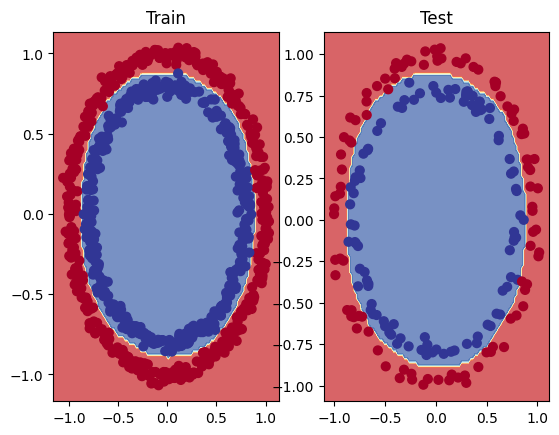

In [74]:
plt.Figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,x_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,x_test,y_test)
